In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.prep.correction as corr
import neutompy as ntp
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import algotom.prep.removal as rem
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
instrument = "/HFIR/CG1D"
# instrument = "/SNS/VENUS"
ipts = "33285"
###################### need to change end

# Locate scans

In [3]:
########### CT scan ############
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data"
ct_loc = instrument + "/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data"
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
print("Scans:", sorted(os.listdir(ct_loc)))
########### OB ############
ob_loc = instrument + "/IPTS-"+ipts+"/raw/ob"
print("OBs:", sorted(os.listdir(ob_loc)))
########### DC scan ############
dc_loc = instrument + "/IPTS-"+ipts+"/raw/dc"
print("DCs:", sorted(os.listdir(dc_loc)))

Scans: ['2024_09_26_AG1_2CT', '2024_10_20_AG']
OBs: ['2024_09_24_30s', '2024_09_26_AG1_2CT', '2024_10_20_AG']
DCs: ['2024_09_24_30s', '2024_10_21_nGI']


In [4]:
###################### need to change start
sample_name = "2024_10_20_AG"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2024_10_20_AG")
dc_dir = os.path.join(dc_loc, "2024_10_21_nGI")
###################### need to change end
gamma_diff = 20
img_per_ang = 1
mars_ct = True
# mars_ct = False
# golden_ratio = True
golden_ratio = False
filter_name = None  # can be used to seperate 2 CTs in the same folder
end_ang = 359.89 # Will *NOT* be used if the CT file names contain angle info and 'mars_ct' is True
ct_name = "*sample*" # Will not be used if follows the default file structure
ob_name = "*OB*" # Will not be used if follows the default file structure
dc_name = "*DC*" # Will not be used if follows the default file structure
svmbir_path = instrument + "/IPTS-"+ipts+"/shared/autoreduce/svmbir/"

# Load all data files (CT, OB and DC)

In [5]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj000_idx, proj180_idx, proj360_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name, 
                                                                                   filter_name=filter_name, img_per_ang=img_per_ang,
                                                                                  mars_ct=mars_ct, golden_ratio=golden_ratio)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Normal CT naming convention
611


Found index of 180 degree projections: 305 of angle 179.95
Found index of 0 degree or first projections: 0 of angle 0.0
Found index of 360 degree or last projections: 610 of angle 359.9
Loading 611 CT projections...
611 CT projections loaded!
Shape: (611, 6200, 6200)
Loading 5 Open Beam (OB) images...
5


5 Open Beam (OB) images loaded!
Shape: (5, 6200, 6200)
Loading 10 Dark Current (DC) images...
10


10 Dark Current (DC) images loaded!
Shape: (10, 6200, 6200)


# Visual verification of loaded files

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integerError.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 2.4982604389078915 s


Text(0.5, 1.0, 'Ratio')

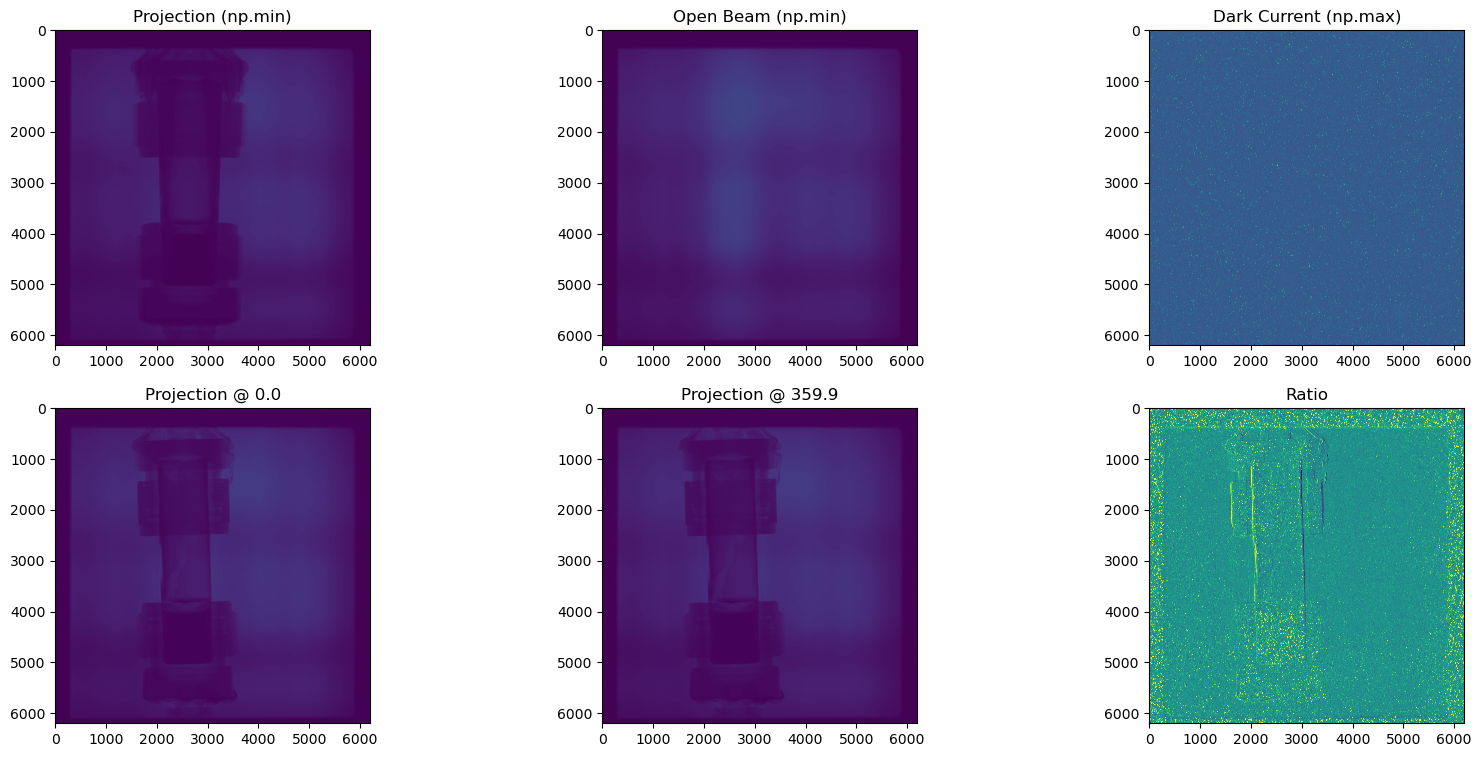

In [6]:
vmax = tomopy.misc.corr.remove_outlier(ob_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).max()
vmin = tomopy.misc.corr.remove_outlier(proj_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).min()
##################
t0 = timeit.default_timer()
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
f, ax = plt.subplots(2, 3, figsize=(20, 9))
ax[0][0].imshow(proj_min, vmax=vmax, vmin=vmin)
ax[0][0].set_title('Projection (np.min)')
ax[0][1].imshow(ob_min, vmax=vmax, vmin=vmin)
ax[0][1].set_title('Open Beam (np.min)')
ax[0][2].imshow(dc_max, vmax=vmin+1000, vmin=vmin)
ax[0][2].set_title('Dark Current (np.max)')
ax[1][0].imshow(proj_raw[0], vmax=vmax, vmin=vmin)
ax[1][0].set_title('Projection @ {}'.format(ang_deg[0]))
ax[1][1].imshow(proj_raw[proj360_idx], vmax=vmax, vmin=vmin)
ax[1][1].set_title('Projection @ {}'.format(ang_deg[proj360_idx]))
ax[1][2].imshow(proj_raw[proj360_idx]/proj_raw[0], vmax=1.1, vmin=0.9)
ax[1][2].set_title('Ratio')

# Resize/crop

Cropped:


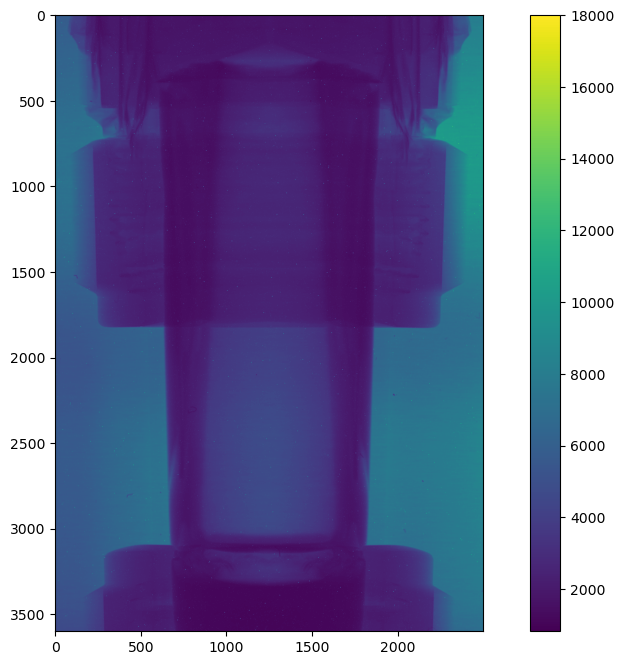

In [7]:
###################### need to change start
# crop = False
crop = True

crop_left = 1400#1580#1720#950
crop_right = 3900#3270#3300#3850
###################### need to change end
crop_top = 700#1680#630
crop_bottom = 4300#-1070#-270
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Cropped:")
plt.imshow(proj_crop_min, vmax=18000)#vmax)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi_dict', crop_roi_dict)

# Remove Outliers

In [8]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
# proj_crop = tomopy.misc.corr.remove_outlier_cuda(proj_crop, gamma_diff).astype(np.ushort)
# ob_crop = tomopy.misc.corr.remove_outlier_cuda(ob_crop, gamma_diff).astype(np.ushort)
# dc_crop = tomopy.misc.corr.remove_outlier_cuda(dc_crop, gamma_diff).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)
history_dict = rocku.log(history_dict, 'gamma_diff', gamma_diff)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 13.96876711025834 s


# Rebin Pixels

In [9]:
# pixel_bin_size = 1
pixel_bin_size = 2
func = np.sum
# dtype = np.float16
dtype = np.float32
# dtype = np.float64
#################################################
t0 = timeit.default_timer()
proj_crop_resized = rocku.bin_pix(proj_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
ob_crop_resized = rocku.bin_pix(ob_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
dc_crop_resized = rocku.bin_pix(dc_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
proj_crop_min_resized = rocku.bin_pix(proj_crop_min, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 33.28962652711198 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalization Done!
float32
(611, 1800, 1250)
Normalization Time: 2.0212810188531876 s


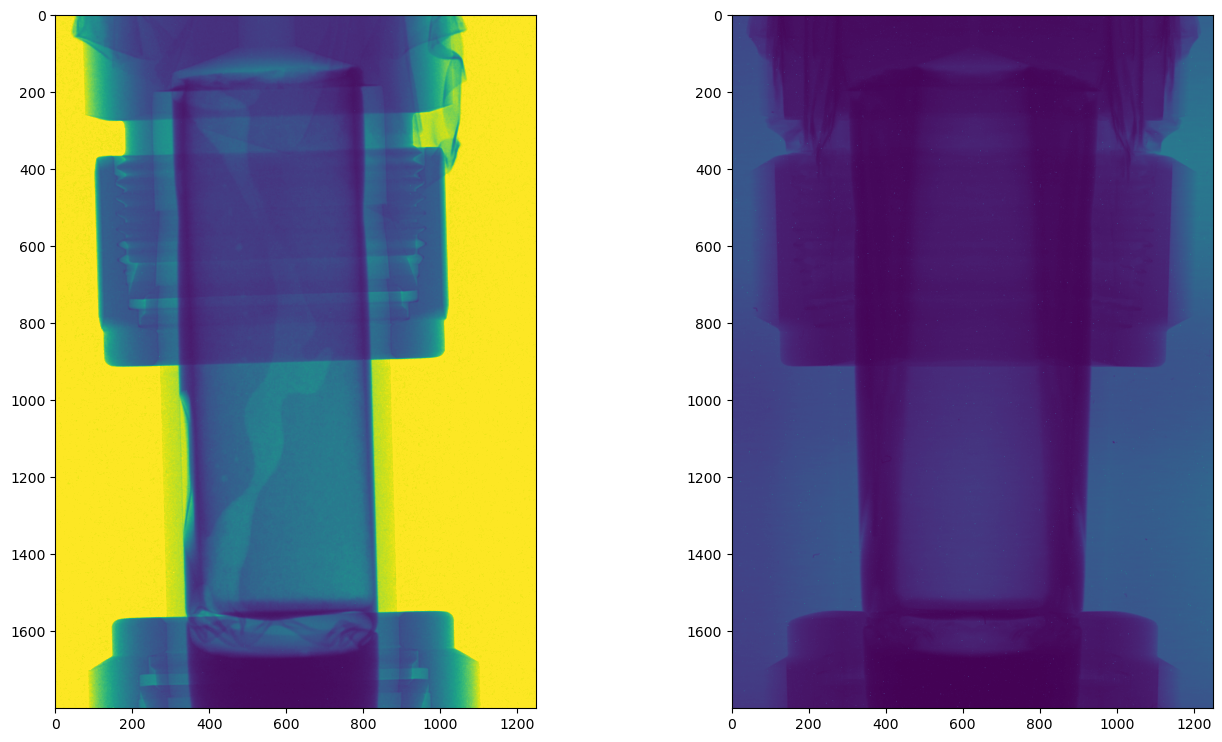

In [10]:
#################################################
t0 = timeit.default_timer()
proj_norm, proj_mi_dc, ob_med, dc_med = rocku.normalize(proj_crop_resized, ob_crop_resized, dc_crop_resized)
print(proj_norm.dtype)
print(proj_norm.shape)
t1 = timeit.default_timer()
print("Normalization Time: {} s".format(t1-t0))
proj_norm = rocku.remove_nan(proj_norm, val=0, ncore=ncore)
proj_norm = rocku.remove_neg(proj_norm, val=0, ncore=ncore)

f, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].imshow(proj_norm[0], vmin=0, vmax=1)
# ax[0].set_title('0 deg')
ax[1].imshow(proj_crop_min_resized)
# ax[1].set_title('180 deg (flipped)')

history_dict = rocku.log(history_dict, 'normalization', True)
history_dict = rocku.log(history_dict, 'pixel_bin_size', pixel_bin_size)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


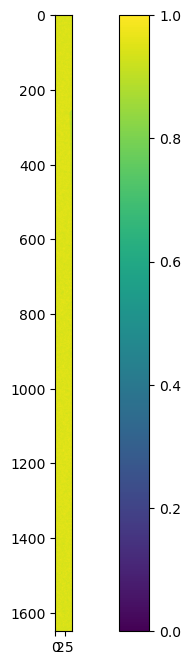

In [11]:
###################### need to change start
fluc_corr = True
# fluc_corr = False
bg_left = 5
bg_right = 50
bg_top = 150#750
bg_bottom = 2000#3000
###################### need to change end
if fluc_corr:
    bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
    bg_min = np.min(bg_stack, axis=0)
    print("Beam fluctuation ROI:")
    plt.imshow(bg_min, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

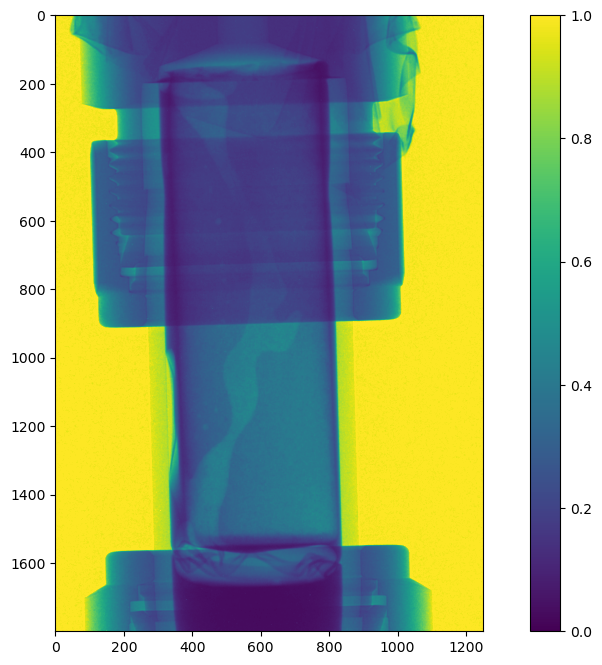

Time: 12.539639665745199 s


In [12]:
if fluc_corr:
    t0 = timeit.default_timer()
    proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
    plt.imshow(proj_norm[0], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    t1 = timeit.default_timer()
    print("Time: {} s".format(t1-t0))
    bg_roi_dict = {
        'left': bg_left,
        'right': bg_right,
        'top': bg_top,
        'bottom': bg_bottom
    }
    history_dict = rocku.log(history_dict, 'beam_fluc_corr', fluc_corr)
    history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi_dict', bg_roi_dict)

# Minus log conversion

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer/SNS/users/y9z/miniconda3/envs/rockit/lib/python3.10/site-packages/tomopy/misc/corr.py:747: UserWarning: The tomocuda is not support, using cpu outlier removal
  warnings.warn("The tomocuda is not support, using cpu outlier removal")


Minus Log Time: 0.1590183819644153 s


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Outlier Removal Time: 1.1782838269136846 s


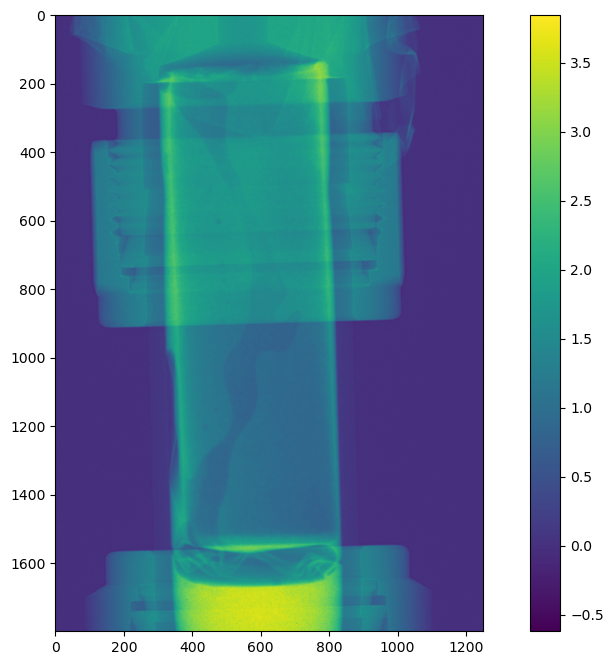

In [13]:
t0 = timeit.default_timer()
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore, out=None)
t1 = timeit.default_timer()
history_dict = rocku.log(history_dict, 'minus_log', True)
print("Minus Log Time: {} s".format(t1-t0))
## Optional to removal outliers again in mlog
mlog_diff = 0.2
t0 = timeit.default_timer()
proj_mlog = tomopy.misc.corr.remove_outlier_cuda(proj_mlog, mlog_diff)
t1 = timeit.default_timer()
print("Outlier Removal Time: {} s".format(t1-t0))
proj_mlog = rocku.remove_neg(proj_mlog, val=0, ncore=ncore)
sino_mlog = np.moveaxis(proj_mlog, 1, 0)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

In [14]:
# # Clockwise rotate the image (Only required when the rotation axis is horizontal in the raw images)
# proj_mlog = proj_mlog.swapaxes(-2,-1)[...,::-1]
# sino_mlog = sino_mlog.swapaxes(-2,-1)[...,::-1]
# proj_crop_min_resized = np.rot90(proj_crop_min_resized[:], k=1, axes=(1,0))

# Find and correct tilt

Text(0.5, 1.0, 'Reference')

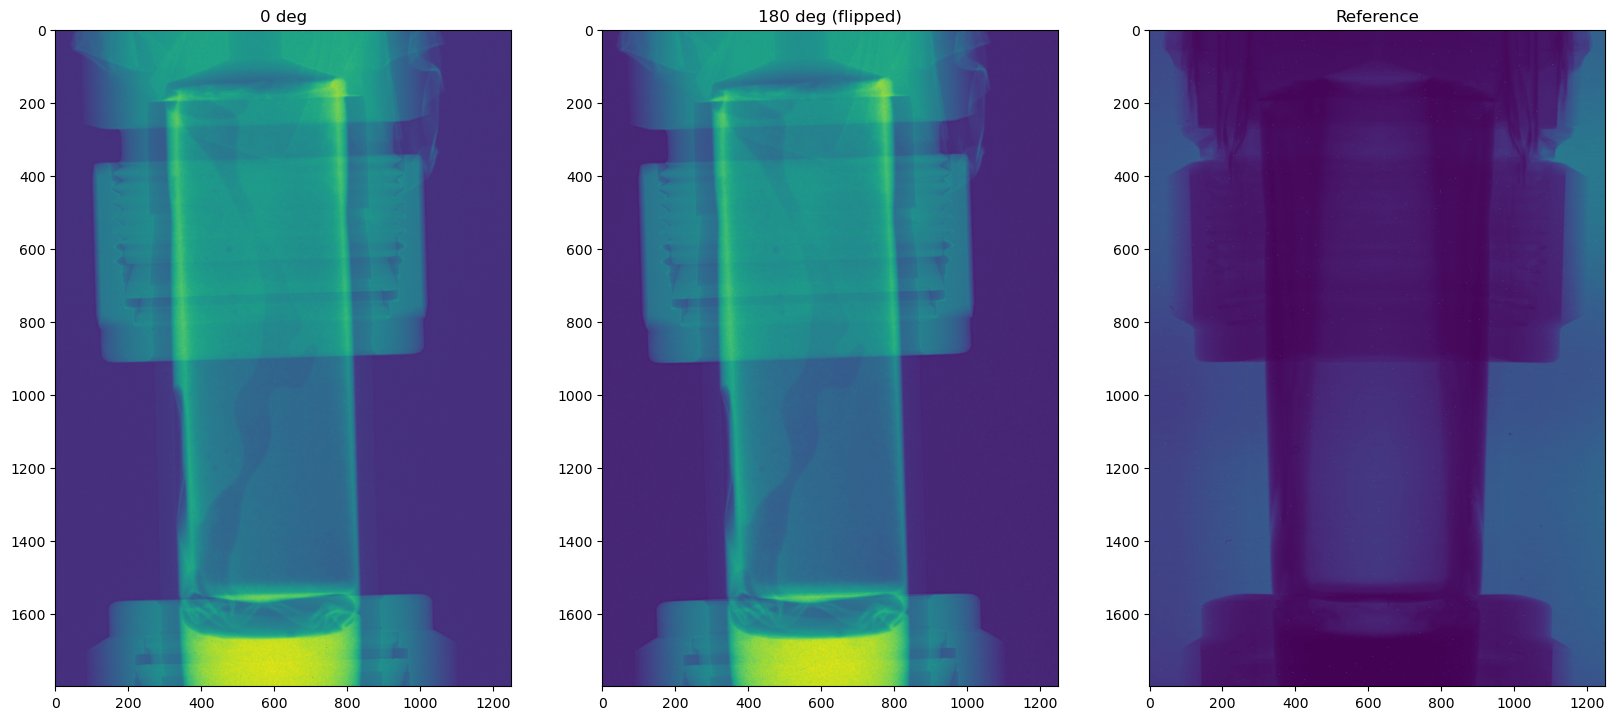

In [15]:
f, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].imshow(proj_mlog[proj000_idx])
ax[0].set_title('0 deg')
ax[1].imshow(np.fliplr(proj_mlog[proj180_idx]))
ax[1].set_title('180 deg (flipped)')
ax[2].imshow(proj_crop_min_resized)
ax[2].set_title('Reference')

> Finding the rotation axis position...
> Select ROI 1
ROI selected: ymin = 343 , ymax = 959 , xmin = 35 , xmax = 1212
> Select ROI 2
ROI selected: ymin = 1111 , ymax = 1623 , xmin = 112 , xmax = 1133
Rotation axis Found!
offset = 0.0    tilt angle = 0.10572983002240577 °
average of residuals  =  0.028093807


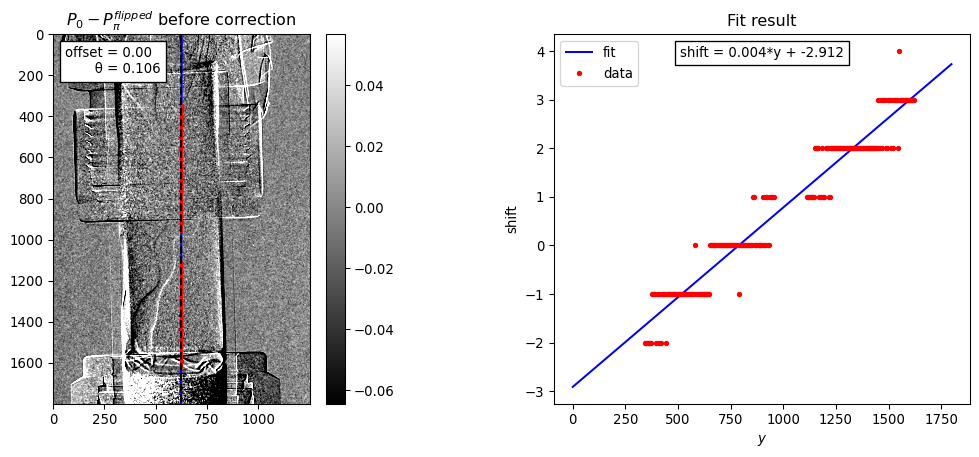

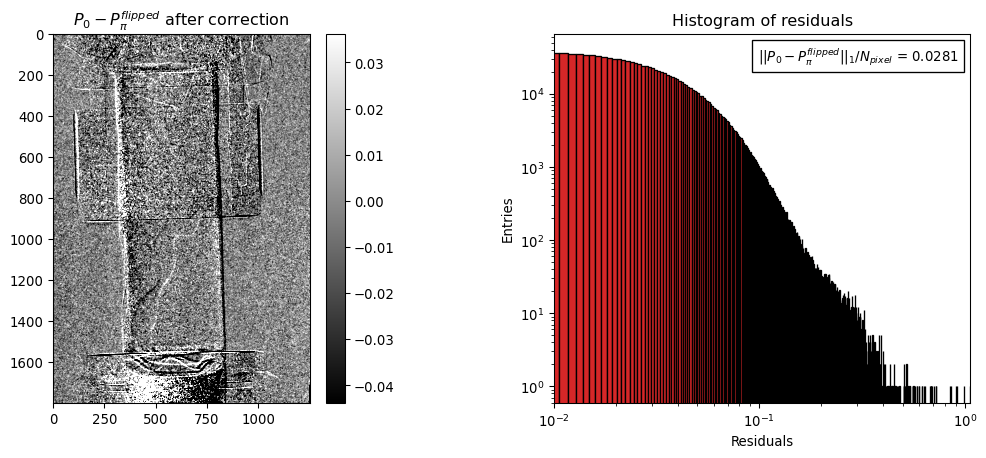

> Correcting rotation axis misalignment...


100%|███████████████████████████████████| 611/611 [00:04<00:00, 129.95 images/s]


In [16]:
# Tilt correction (neutompy)
nroi = 2
tilt_img = True
# tilt_img = False
theta_input = None
#################################################
proj_0 = proj_mlog[proj000_idx]
proj_180 = proj_mlog[proj180_idx]
if tilt_img:
    if theta_input is None:
        tt_offset, tt_ang = ntp.find_COR(proj_0=proj_0, proj_180=proj_180, nroi=nroi, ref_proj=proj_crop_min_resized)#proj_0)
    else:
        tt_ang = theta_input
    proj_mlog_tilt = ntp.correction_COR(norm_proj=proj_mlog, proj_0=proj_0, proj_180=proj_180, shift=0, theta=tt_ang)
else:
    proj_mlog_tilt = proj_mlog[:]
history_dict = rocku.log(history_dict, 'tilt_corr_used', 'neutompy')

# Focused ROI for the next steps

In [17]:
### Define ROI
# define_roi = True
define_roi = False
#######################
if define_roi:
    t0 = timeit.default_timer()
    proj_mlog_tilt_min = np.max(proj_mlog_tilt, axis=0)
    t1 = timeit.default_timer()
    print("Time: {} s".format(t1-t0))
    plt.imshow(proj_mlog_tilt_min, vmax=1.8)
    plt.colorbar()
    plt.show()
else:
    proj_mlog_tilt_min = proj_mlog_tilt[0][:]

In [18]:
### Define ROI
define_roi_top = 1750#270
define_roi_bottom = 2000
############################################
############################################
###################### need to change end
# shift = int(abs(tt_offset))
define_roi_left = 0
# define_roi_right = -1*shift
define_roi_right = -1

proj_mlog_tilt_min_crop = rocku.crop(proj_mlog_tilt_min, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
proj_mlog_roi = rocku.crop(proj_mlog_tilt, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
# Covert to sinogram
sino_mlog_roi = np.moveaxis(proj_mlog_roi, 1, 0)

define_roi_dict = {
    'left': define_roi_left,
    'right': define_roi_right,
    'top': define_roi_top,
    'bottom': define_roi_bottom
}
history_dict = rocku.log(history_dict, 'define_roi', define_roi)
if define_roi:
    history_dict = rocku.log(history_dict, 'define_roi_dict', define_roi_dict)
    print("Defined ROI:")
    plt.imshow(proj_mlog_tilt_min_crop, vmax=1.5)
    plt.colorbar()
    plt.show()

# Test tilt and COR by reconstruct slices

In [19]:
print("Finding the center of rotation (COR)...")
t0 = timeit.default_timer()
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center_180 = calc.find_center_vo(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)][:proj180_idx], ncore=ncore)
print('Estimated center of rotation (COR) with 0-180 deg:', rot_center_180)
history_dict = rocku.log(history_dict, 'rot_center_180', rot_center_180)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

t0 = timeit.default_timer()
rot_center_360 = calc.find_center_360(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)], win_width=800, ncore=ncore)[0]
print('Estimated center of rotation (COR) with 0-360 deg:', rot_center_360)
history_dict = rocku.log(history_dict, 'rot_center_360', rot_center_360)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Finding the center of rotation (COR)...
Estimated center of rotation (COR) with 0-180 deg: 624.0
Time: 0.6306303790770471 s
Estimated center of rotation (COR) with 0-360 deg: 625.0
Time: 29.82122480729595 s


Center of rotation: 625.0
Tilt theta applied: 0.10572983002240577
Time cost 0.36504722014069557 s


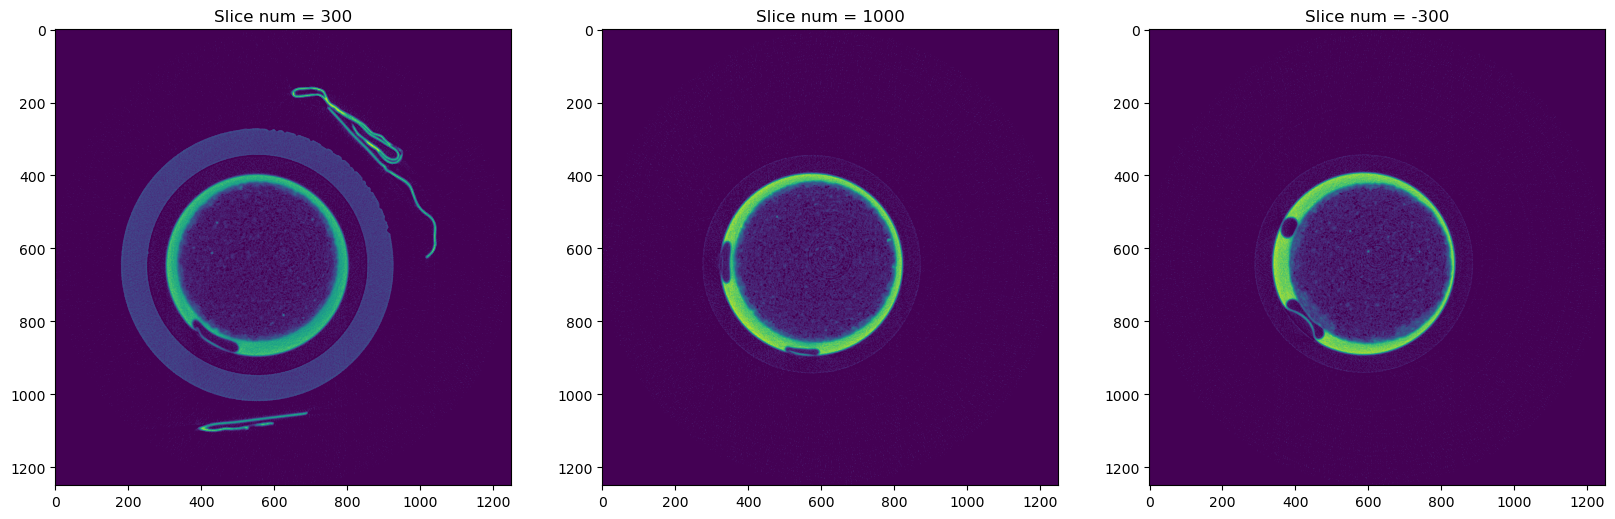

In [23]:
###################### need to change start
slice_idx_list = [300, 1000, -300]
# pix_um = None
# pix_um = 42 # um
# pix_um = 7.8*pixel_bin_size # um
pix_um = 15.97*pixel_bin_size # um
# pix_um = 15.97*3 # um
full_360 = True
# full_360 = False
idx_offset = 0
# rot_center = rot_center_180
rot_center = rot_center_360
recon_crop = False
# recon_crop = True
recon_crop_left = 170
recon_crop_right = 1400
recon_crop_top = 170
recon_crop_bottom = 1400
###################### need to change end
#####################################
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx + 1
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx + 1 + idx_offset
######################################
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}
## Recon some slices to check the sharpness
history_dict = rocku.log(history_dict, 'rot_center', rot_center)
print("Center of rotation:", rot_center)
history_dict = rocku.log(history_dict, 'tilt_corr_theta', tt_ang)
print("Tilt theta applied:", tt_ang)
t0 = timeit.default_timer()
f, ax = plt.subplots(1, len(slice_idx_list), figsize=(20, 20))

for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx, start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0)
    ax[num].set_title('Slice num = {}'.format(e_idx))
t1 = timeit.default_timer()
print("Time cost {} s".format((t1-t0)))

In [ ]:
### Optional tests with different slice index
slice_idx_list = [100, 300]
f, ax = plt.subplots(1, len(slice_idx_list), figsize=(20, 20))
for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx], rot_center, angles=ang_rad, 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0)#, vmax=3)
    ax[num].set_title('Slice num = {}'.format(e_idx))

# Ring Artifact Removal

In [25]:
ring_algo = None
# ring_algo = 'Vo' ######### (a) Vo's approach from tomopy (faster)
# ring_algo = 'bm3d' ######### (b) bm3d approach (slow, but generally better)
# ring_algo = 'bm3dgpu' ######### (b) bm3d approach (slow, but generally better)
# ring_algo = 'bm3dornl' ######### (c) bm3dornl GPU
#################################################################################
t0 = timeit.default_timer()
proj_mlog_rmv = rocku.remove_ring(proj_mlog=proj_mlog_roi, ring_algo=ring_algo, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format(round((t1-t0)/60),3))
history_dict = rocku.log(history_dict, 'ring_removal', ring_algo)
proj_mlog_to_recon = proj_mlog_rmv.astype(np.float32)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

Time cost 0 min


In [27]:
slice_num = None
# slice_num = 140
#######################
if ring_algo is not None:
    if slice_num is None:
        slice_num = int(proj_mlog_roi.shape[1]/2)
    f, ax = plt.subplots(1, 3, figsize=(20, 9))
    ax[0].imshow(sino_mlog_roi[slice_num])
    ax[0].set_title('Before ring removal')
    ax[1].imshow(sino_mlog_to_recon[slice_num])
    ax[1].set_title('After ring removal')
    ax[2].imshow(sino_mlog_to_recon[slice_num]-sino_mlog_roi[slice_num])
    ax[2].set_title('Difference')

# Reconstruction
## Preview different recon methods

Center of rotation 625.0


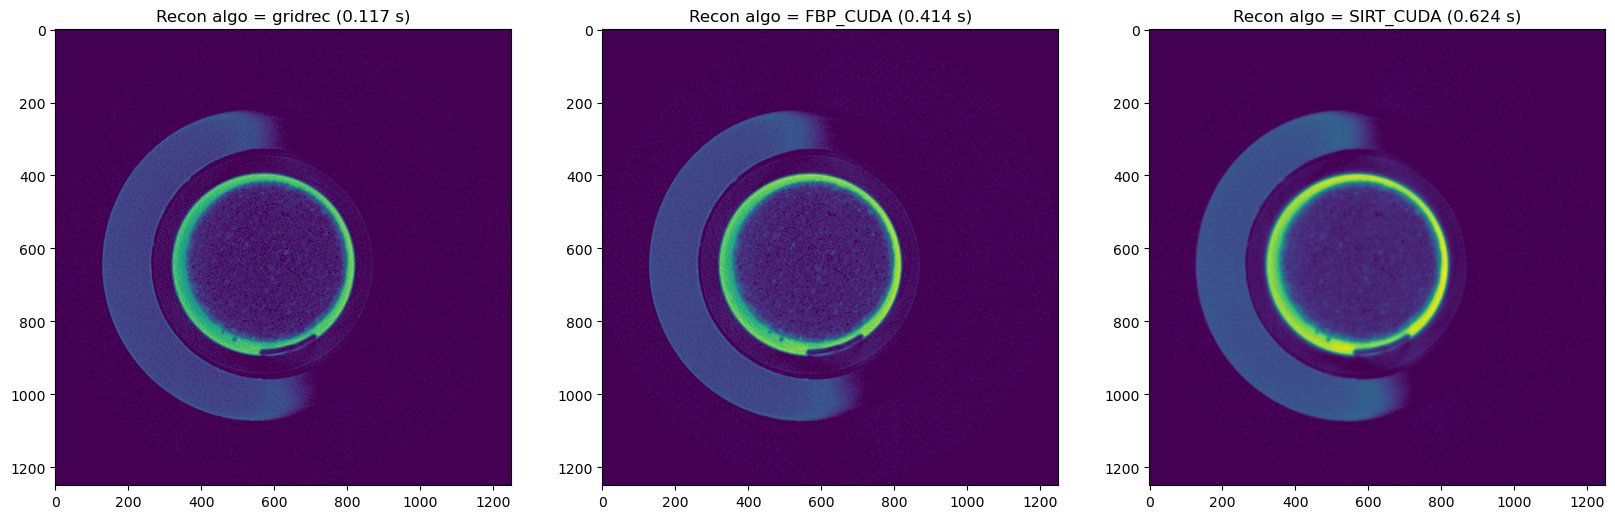

In [28]:
slice_num = None
# slice_num = -110
full_360 = True
# full_360 = False
idx_offset = 20 # adding this many projections past 180 deg if full_360 is False
num_iter = 200 # for iterative recon only
recon_algo_list = ['gridrec',
                   # 'fbp', 
                   # 'FBP', 'SIRT', 'SART', 'ART', 'CGLS', 
                   'FBP_CUDA',
                   'SIRT_CUDA',
                   # 'SART_CUDA',
                   # 'CGLS_CUDA',
                   # 'svmbir',
                   ]
#######################
#######################
apply_log = False
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx + 1
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx + 1 + idx_offset
if slice_num is None:
    slice_num = int(proj_mlog_roi.shape[1]/2)
print("Center of rotation", rot_center)
f, ax = plt.subplots(1, len(recon_algo_list), figsize=(20, 20))
for num, each_algo in enumerate(recon_algo_list):
    t0 = timeit.default_timer()
    rec_img1 = rocku.recon_a_slice(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], proj_mlog_to_recon[start_ang_idx:end_ang_idx,slice_num,:], rot_center, ang_rad[start_ang_idx:end_ang_idx], each_algo, ncore, svmbir_path, num_iter=num_iter, apply_log=apply_log)
    rec_img1 = rocku.crop(rec_img1, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    t1 = timeit.default_timer()
    if len(recon_algo_list)>1:
        ax[num].imshow(rec_img1, vmin=0)
        ax[num].set_title('Recon algo = {} ({} s)'.format(each_algo, round(t1-t0, 3)))
    else:
        ax.imshow(rec_img1, vmin=0)
        ax.set_title('Recon algo = {} ({} s)'.format(each_algo, round(t1-t0, 3)))

# Beam hardening correction (optional)

In [ ]:
###################### need to change start
idx = 1600
line_loc = 370
bh_q = 0.02
bh_n = 15
bh_opt = True
###################### need to change end
t0 = timeit.default_timer()
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

proj_norm_to_recon = np.exp(np.negative(proj_mlog_to_recon))
proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon, q=bh_q, n=bh_n, opt=bh_opt)
proj_mlog_to_recon_bh_corr = np.negative(np.log(proj_norm_to_recon_bh_corr))
sino_mlog_to_recon_bh_corr = np.moveaxis(proj_mlog_to_recon_bh_corr, 1, 0)
rec_img_bh_corr = rec.gridrec_reconstruction(sino_mlog_to_recon_bh_corr[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img_bh_corr = rocku.crop(rec_img_bh_corr, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

In [ ]:
start = (line_loc, 0)
end = (line_loc, rec_img.shape[1]-1)
profile = profile_line(rec_img, start, end)
profile_bh_corr = profile_line(rec_img_bh_corr, start, end)
fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('Image')
ax[0][0].imshow(rec_img)
ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[0][1].set_title('Profile')
ax[0][1].plot(profile)
# ax[1][0].set_title('Image_BH')
ax[1][0].imshow(rec_img_bh_corr)
ax[1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
# ax[1][1].set_title('Profile_BH')
ax[1][1].plot(profile_bh_corr)
fig.show()
t1 = timeit.default_timer()
print("Time: {} mins".format((t1-t0)/60))

# Pick one method to recon the defined ring removed ROI

In [29]:
pix_um = 15.97 * pixel_bin_size # um
# pix_um = 7.8 * pixel_bin_size # um
# pix_um = 42 # um
# pix_um = None

recon_algo = 'gridrec'
# recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'
# recon_algo = 'fbp'
#####['gridrec','fbp', 'FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA','SIRT_CUDA','SART_CUDA','CGLS_CUDA','svmbir',]


# slice_by_slice = True
slice_by_slice = False

name_str = None
# name_str = 'test'
# name_str = 'lamino'
############################################################
save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
save_to = save_loc + save_name_str
##################################
if slice_by_slice:
    rocku.recon_slice_by_slice(sino_mlog_to_recon, proj_mlog_to_recon, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, save_to, 
                               recon_crop=recon_crop, recon_crop_roi_dict=recon_crop_roi_dict, pix_um=pix_um, num_iter=num_iter, apply_log=apply_log)
else:
    recon = rocku.recon_full_volume(proj_mlog_to_recon, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, pix_um=pix_um, num_iter=num_iter, apply_log=apply_log)
if pix_um is not None:
    pix_cm = pix_um/10000
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
else:
    history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
history_dict = rocku.log(history_dict, 'recon_num_iter', num_iter)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

Time cost 0.05870702535224458 min


# Crop reconstructed volume

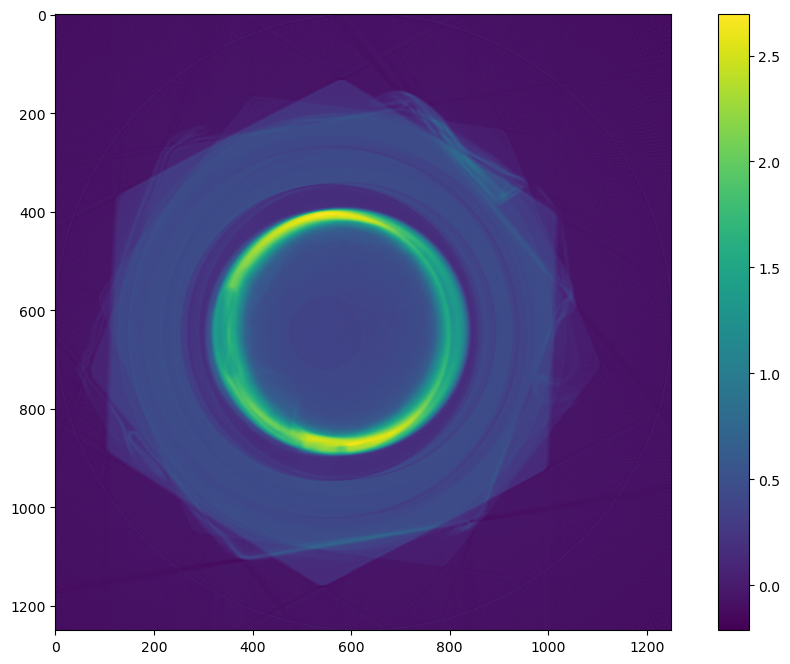

In [30]:
if not slice_by_slice:
    recon_max = np.mean(recon, axis=0)
    plt.imshow(recon_max)#, vmax=2)
    plt.colorbar()
    plt.show()

Recon ROI:


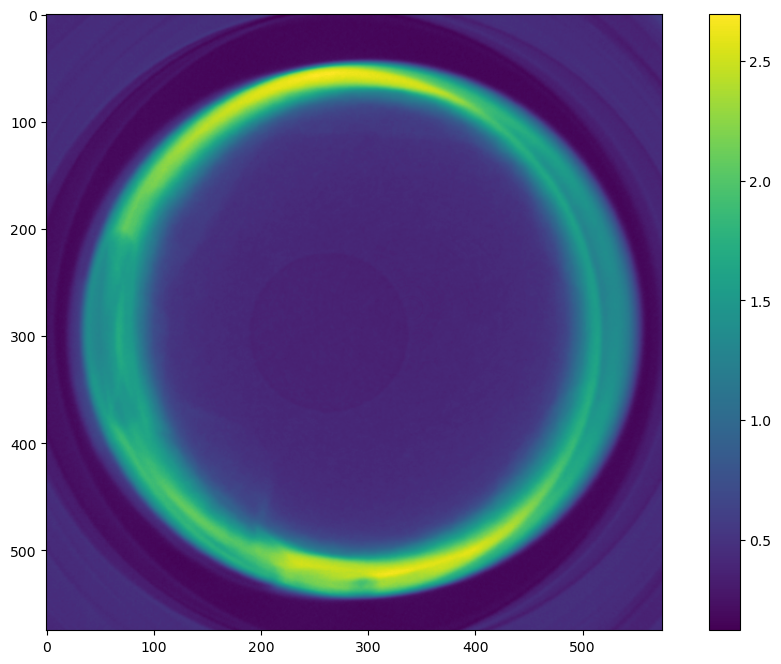

In [31]:
if not slice_by_slice:
    ###################### need to change start
    ### Define crop roi
    recon_crop = True
    # recon_crop = False
    # recon_crop_left = 550
    # recon_crop_right = 1250
    # recon_crop_top = 550
    # recon_crop_bottom = 1250
    recon_crop_left = 285
    recon_crop_right = 860
    recon_crop_top = 350
    recon_crop_bottom = 925
    ###################### need to change end
    recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    recon_crop_roi_dict = {
        'left': recon_crop_left,
        'right': recon_crop_right,
        'top': recon_crop_top,
        'bottom': recon_crop_bottom
    }
    if recon_crop:
        print("Recon ROI:")
        plt.imshow(recon_max_crop)#, vmax=2)
        plt.colorbar()
        plt.show()

In [32]:
# Apply cropping to the whole recon volume and save recon cropping info to h5
if not slice_by_slice:
    recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
    if recon_crop:
        history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# Export recon files

In [33]:
if not slice_by_slice:
    ################ change save path for your own
    name_str = None
    # name_str = 'lamino'
    ############################################################
    save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
    num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
    if name_str is not None:
        save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
    else:
        save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
    save_to = save_loc + save_name_str
    print(save_to)
    dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-33285/shared/processed_data/rockit/2024_10_20_AG_611proj_gridrec


# Export to HDF5

In [34]:
history_dict

{'crop': True,
 'crop_roi_dict': {'left': 1400, 'right': 3900, 'top': 700, 'bottom': 4300},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 2,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 5,
  'right': 50,
  'top': 150,
  'bottom': 2000},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'define_roi': False,
 'rot_center_180': 624.0,
 'rot_center_360': 625.0,
 'rot_center': 625.0,
 'tilt_corr_theta': 0.10572983002240577,
 'ring_removal': None,
 'pixel_size_um': 31.94,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 611,
 'recon_algo': 'gridrec',
 'recon_num_iter': 200,
 'recon_crop': True,
 'recon_crop_roi': {'left': 285, 'right': 860, 'top': 350, 'bottom': 925}}

In [37]:
name_str = None
# name_str = 'lamino'
############################################################
num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
output_hdf5_dir = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '.h5'
print(output_hdf5)

/HFIR/CG1D/IPTS-33285/shared/autoreduce/hdf5/2024_10_20_AG_611proj_gridrec.h5


In [43]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    if fluc_corr:
        f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm_pre_tilt', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_pre_tilt', data=proj_mlog)
    f.create_dataset('tomo/proj/proj_mlog_pre_ring', data=proj_mlog_roi)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_mlog_pre_tilt', data=sino_mlog)
    f.create_dataset('tomo/sino/sino_mlog_pre_ring', data=sino_mlog_roi)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj360_idx', data=(proj360_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    # f.create_dataset('tomo/recon/recon_unit', data=(recon_unit,))
    if not slice_by_slice:
        f.create_dataset('tomo/recon/recon_volume', data=recon)

In [ ]:
os.listdir(svmbir_path)